# L-RVGA

In [1]:
import jax
import chex
import distrax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from rebayes.utils import datasets
from jaxtyping import Array, Float
from rebayes import gauss_approx as vga

In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
key = jax.random.PRNGKey(314)
key_init, key_eval = jax.random.split(key)

## Iterated RVGA
We take Equation 36 of L-RVGA (§4.2.1) and skip the extra covariance update.

$$
\begin{aligned}
    {\hat{P}_t}^{-1}
    &= P_{t-1}^{-1} - \mathbb{E}_{\theta \sim \mathcal{N}(\mu_{t-1}, P_{t-1})}\left[\nabla_\theta \log p(y_t \vert \theta)\right]\\
    {\hat{\mu}_t} &= \mu_{t-1} + \hat{P}_t \mathbb{E}_{ \theta\sim\mathcal{N}(\mu_{t-1}, P_{t-1}) }\left[ \nabla_\theta \log p(y_t \vert \theta) \right]\\
    \mu_t &= \mu_{t-1} + \hat{P}_t \mathbb{E}_{\theta\sim\mathcal{N}(\hat{\mu}_t, \hat P_t)}\left[\nabla_\theta \log p(y_t \vert \theta)\right]
\end{aligned}
$$

## $X_t$ estimate

Given $K$ samples, $X_t$ is given by $X_t = \frac{1}{\sqrt{K}}(c_1, \ldots, c_K)$ where

$$
    c_k = \frac{\partial h}{\partial \theta}(\theta_k)\text{Cov}(y\vert\theta_k) 
$$

In the more general case, we have

$$
    -\mathbb{E}_{\theta}\left[-\nabla_\theta \log p(y_t \vert \theta)\right] =\mathbb{E}_\theta\left[\mathbb{E}_y\left[\nabla_\theta p(y\vert\theta) \nabla_\theta p(y\vert\theta)^\intercal\right]\right]
$$

The linear regression L-RVGA FA approximation is given by

$$
    W_t W_t^\intercal + \Psi_t \underset{\text{FA}}{\approx} \alpha_t\left( W_{t-1} W_{t-1}^\intercal + \Psi_{t-1} \right) + \beta x_t x_t^\intercal
$$

In the nonlinear case, the FA approximation is given by

$$
    W_t W_t^\intercal + \Psi_t \underset{\text{FA}}{\approx} W_{t-1} W_{t-1}^\intercal + \Psi_{t-1} + X_t X_t^\intercal
$$

* $M \in \mathbb{R}^{D\times d}$
* $\text{diag}(\Psi) \in\mathbb{R}^D$

In [4]:
@partial(jax.vmap, in_axes=(0, None))
def pred_history(params_flat, X):
    params = reconstruct_fn(params_flat)
    yhat = model.apply(params, X)
    return yhat

## Load rotation MNIST

In [5]:
%%time
np.random.seed(314)
num_train = 100

train, test = datasets.load_rotated_mnist(target_digit=2, n_processes=1)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_train = jnp.array(X_train)[:num_train]
y_train = jnp.array(y_train)[:num_train]

num_test = len(y_test)
# ix_sort = jnp.argsort(y)
# X = X[ix_sort]
# y = y[ix_sort]

CPU times: user 2.62 s, sys: 109 ms, total: 2.72 s
Wall time: 1.82 s


## Load dataset

In [5]:
%%time
dataset = "kin8nm"
train, test = datasets.load_uci_kin8nm()
data, csts = datasets.showdown_preprocess(train, test, n_warmup=1000)

ymean = csts["ymean"]
ystd = csts["ystd"]

warmup_train = data["warmup_train"]
warmup_test = data["warmup_test"]
X_train, y_train = data["train"]
X_test, y_test = data["test"]

CPU times: user 619 ms, sys: 36.2 ms, total: 655 ms
Wall time: 694 ms


## Rebayes

In [6]:
class MLP(nn.Module):
    std: float
    activation: Callable = nn.elu
    
    def setup(self):
        self.mean = nn.Dense(1, use_bias=True)
    
    @nn.compact
    def __call__(self, x):
        """
        Link_fn: h(θ, x) = θ^T x
        """
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        mean = self.mean(x)
        return mean
    
    def log_prob(self, x, y):
        mean = self.__call__(x)
        logprob = distrax.Normal(loc=mean, scale=self.std).log_prob(y).squeeze()
        return logprob

In [7]:
std = 0.5
model = MLP(std=std)

In [57]:
dim_rank = 10
alpha, beta = 1.0, 1.0
eps = 1e-8

hparams = {
    "sigma2": 1e-3,
    "eps": 1e-8
}

bel_init, reconstruct_fn = vga.init_lrvga(key, model, X_train, dim_rank, **hparams)

In [58]:
def fwd_link(mean, bel, x):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std

def log_prob(mean, x, y):
    params = reconstruct_fn(mean)
    logp = model.apply(params, x, y, method=model.log_prob)
    return logp

In [59]:
n_samples = 5
n_inner = 3
n_inner_fa = 2
alpha, beta = 1.0, 1.0
n_train = len(X_train)

estimator = vga.LRVGA(
    fwd_link, log_prob,
    alpha, beta, n_inner, n_inner_fa, n_samples
)

In [60]:
def callback(bel, pred_obs, *args, **kwargs):
    res = {
        "osa-pred": pred_obs,
        "mean": bel.mean
    }
    return res

In [61]:
bel_rebayes, output = estimator.scan(X_train[:n_train], y_train[:n_train], bel=bel_init, callback=callback)
mu_hist = jax.block_until_ready(output["mean"])

  0%|          | 0/5554 [00:00<?, ?it/s]

test R-MAE: 0.4309
train R-MAE: 0.4361


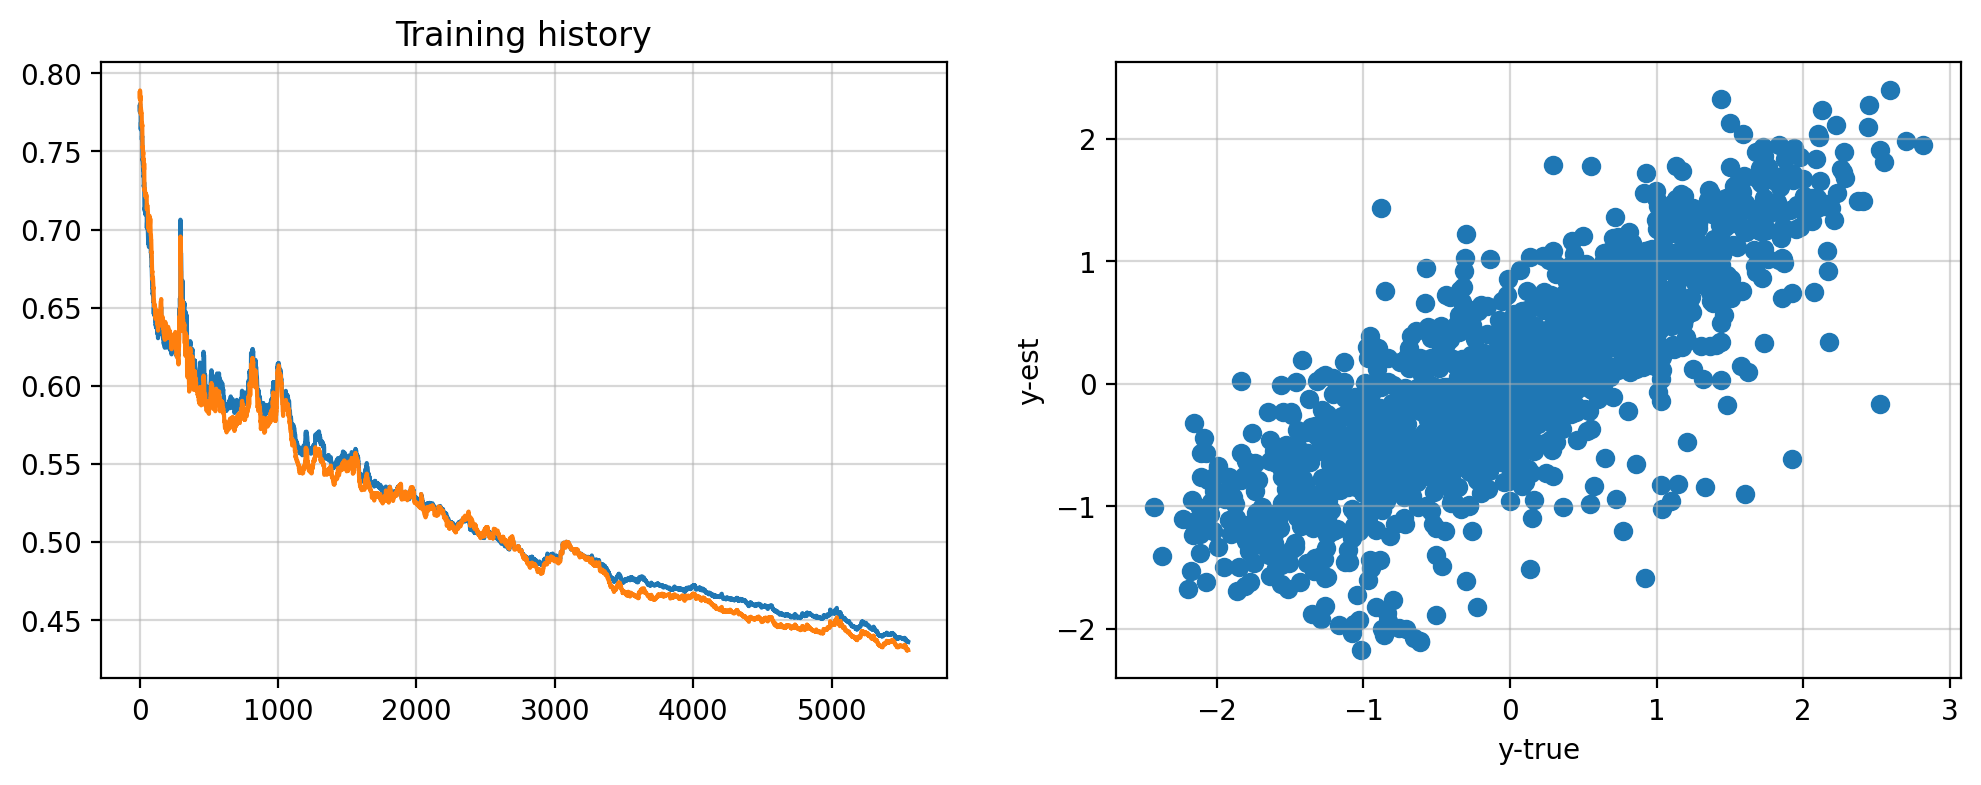

In [62]:
params_final = reconstruct_fn(mu_hist[-1])
yhat_test = model.apply(params_final, X_test).ravel()

yhat_hist_test = pred_history(mu_hist, X_test).squeeze()
yhat_hist_train = pred_history(mu_hist, X_train).squeeze()

err_hist_test = jnp.abs(yhat_hist_test - y_test).mean(axis=-1)
err_hist_train = jnp.abs(yhat_hist_train - y_train).mean(axis=-1)

rmae = err_hist_test[-1]
rmae_train = err_hist_train[-1]

print(f"test R-MAE: {rmae:0.4f}")
print(f"train R-MAE: {rmae_train:0.4f}")


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(err_hist_train, label="train")
ax[0].plot(err_hist_test, label="test")
ax[0].set_title("Training history")
ax[0].grid(alpha=0.5)


ax[1].scatter(y_test, yhat_test)
# ax[1].plot([0, 180], [0, 180], c="tab:orange", linewidth=2)
ax[1].set_xlabel("y-true")
ax[1].set_ylabel("y-est")
ax[1].grid(alpha=0.5)

In [65]:
import pandas as pd

<AxesSubplot: >

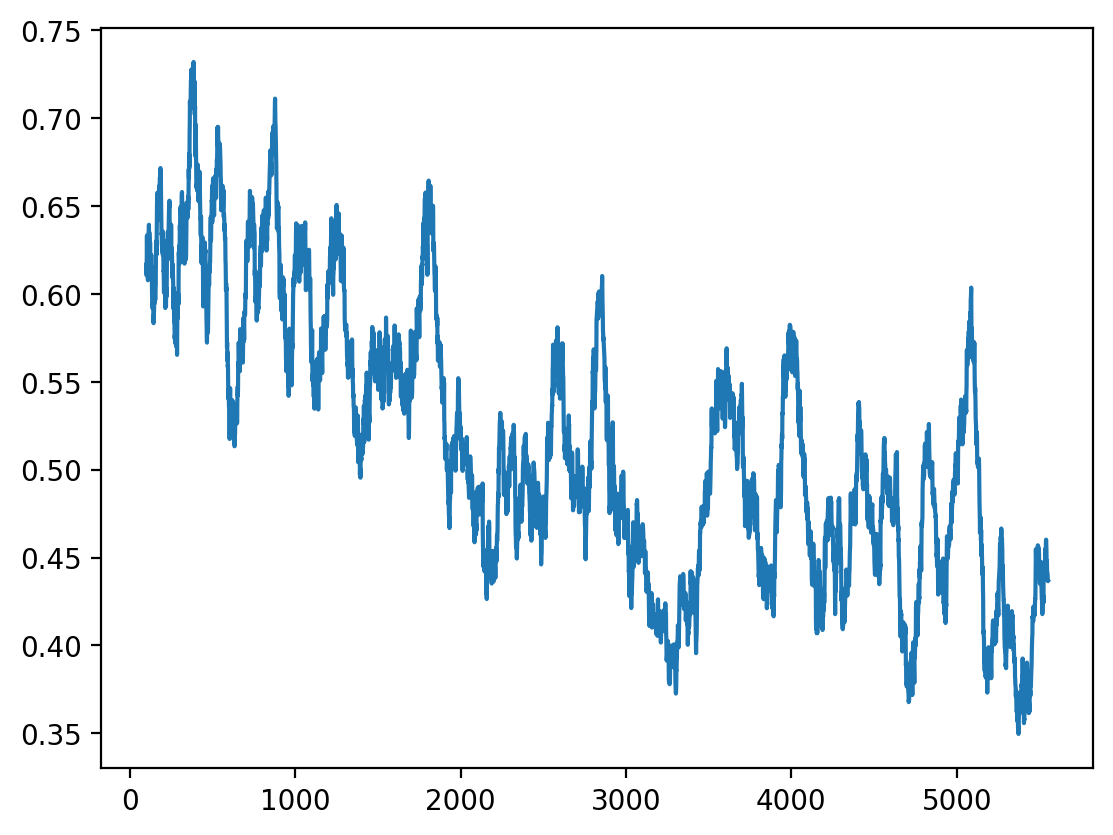

In [66]:
yhat_osa = output["osa-pred"].ravel()

data = jax.tree_map(np.array, {
    "yhat": yhat_osa,
    "y": y_train[:n_train]
})

data = pd.DataFrame(data)
data.diff(axis=1)["yhat"].abs().rolling(100).mean().plot()